We will now attempt to balance the dataset using data augmentation.

## Contents:
- [Installation of Packages](#Installation-of-Packages)
- [Loading of Libraries](#Loading-of-Libraries) 
- [Load Dataset](#Load-Dataset)
- [Data Augmentation](#Data-Augmentation)
- [Modelling](#Modelling)
  - [Modelling using TfidfVectorizer and baseline classifier](#Modelling-using-TfidfVectorizer-and-baseline-classifier)
  - [Modelling and GridSearch using TfidfVectorizer and LinearSVC classifier](#Modelling-and-GridSearch-using-TfidfVectorizer-and-LinearSVC-classifier)

## Installation of Packages

In [24]:
# pip install numpy requests nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.3 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
# from nlpaug.util.file.download import DownloadUtil
# DownloadUtil.download_glove(model_name='glove.6B', dest_dir='.') # Download GloVe model

In [16]:
# pip install gensim>=4.1.2

Note: you may need to restart the kernel to use updated packages.


In [23]:
!kaggle competitions download -c nlp-getting-started
!kaggle datasets download -d rtatman/glove-global-vectors-for-word-representation

/bin/bash: kaggle: command not found
/bin/bash: kaggle: command not found


In [22]:
! unzip /content/glove-global-vectors-for-word-representation.zip

unzip:  cannot find or open /content/glove-global-vectors-for-word-representation.zip, /content/glove-global-vectors-for-word-representation.zip.zip or /content/glove-global-vectors-for-word-representation.zip.ZIP.


The downloaded files have been saved under the [`packages`](../packages/) folder.

## Loading of Libraries

In [197]:
# Import libraries
import nlpaug.augmenter.word as naw
from nlpaug.util import Action
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold # split our data and run hyperparameter search
from sklearn.pipeline import Pipeline # to compactly pack multiple modeling operations
from sklearn.naive_bayes import MultinomialNB # to build our classification model
from sklearn.svm import LinearSVC # to build our classification model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, RocCurveDisplay, roc_auc_score, recall_score, precision_score, f1_score, classification_report # to access results from binary classification task
 
# Import TFIDFVectorizer from feature_extraction.text module in sklearn.
from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm import tqdm
tqdm.pandas()
import time

## Load Dataset
- Set data up for data augmentation
- Train/test split

In [106]:
# Load dataset
sq_forums = pd.read_csv('sq_forums.csv')
print(sq_forums.shape)
sq_forums.head(3)

(27375, 4)


,title,link,reply,forum
0,2020 Biz Class Amenity Kit,http://www.sqtalk.com/forum/forum/singapore-ai...,https://milelion.com/2020/09/30/conf...amenit...,amenity_catering_lounges
1,2020 Biz Class Amenity Kit,http://www.sqtalk.com/forum/forum/singapore-ai...,Originally posted by jammed View Post https:/...,amenity_catering_lounges
2,2020 Biz Class Amenity Kit,http://www.sqtalk.com/forum/forum/singapore-ai...,I’ll report back in 3 week’s time if they are...,amenity_catering_lounges


In [107]:
# Convert y response variable in 'forum' column to 0 for amenity_catering_lounges and 1 for krisflyer
sq_forums['forum'] = sq_forums['forum'].map({'amenity_catering_lounges': 0, 'krisflyer': 1})
sq_forums.head(3)

,title,link,reply,forum
0,2020 Biz Class Amenity Kit,http://www.sqtalk.com/forum/forum/singapore-ai...,https://milelion.com/2020/09/30/conf...amenit...,0
1,2020 Biz Class Amenity Kit,http://www.sqtalk.com/forum/forum/singapore-ai...,Originally posted by jammed View Post https:/...,0
2,2020 Biz Class Amenity Kit,http://www.sqtalk.com/forum/forum/singapore-ai...,I’ll report back in 3 week’s time if they are...,0


In [108]:
# Set data up for data augmentation
sq_forums = sq_forums[['reply','forum']]

In [109]:
sq_forums

,reply,forum
0,https://milelion.com/2020/09/30/conf...amenit...,0
1,Originally posted by jammed View Post https:/...,0
2,I’ll report back in 3 week’s time if they are...,0
3,As we are now in an age of reducing waste thi...,0
4,Originally posted by yflyer View Post - I alw...,0
...,...,...
27370,very true. I just checked out another thread ...,1
27371,"From my last trip, the plastic case was not b...",1
27372,Originally posted by SQFAN View Post Let us k...,1
27373,Looks a lot more durable than the plastic cas...,1


In [110]:
sq_forums['forum'].value_counts()

1    16562
0    10813
Name: forum, dtype: int64

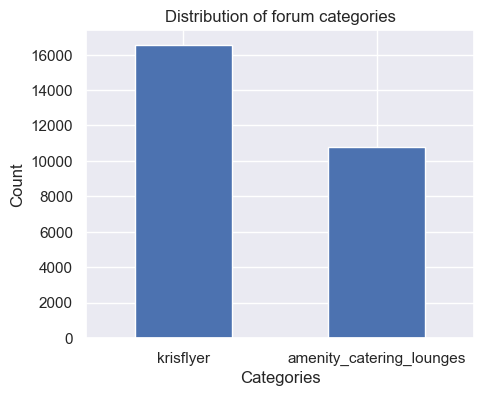

In [111]:
# Recall distribution of target variable as seen in baseline EDA
# Plot bar graph to show distribution of target variable
sns.set(font_scale=1)
sq_forums['forum'].value_counts().plot(kind='bar', figsize=(5, 4), rot=0)
plt.xticks([0,1], ['krisflyer','amenity_catering_lounges'])
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title("Distribution of forum categories");

As the distribution of the target variable is imbalanced, data augmentation of the training dataset will be done to generate 3000 samples from the 'amenity_catering_lounges' category.

In [114]:
# split the data into train and test set 
# so that no samples in the test set will be used for data augmentation
train, test = train_test_split(sq_forums, random_state=42)

In [115]:
train

,reply,forum
22253,Yup chisquared is right privileges should com...,1
20614,Originally posted by HUGE AL View Post KF is ...,1
8829,"Seems to be a *G lounge, but do the dragons a...",0
3208,Originally posted by milehighj View Post Gene...,0
14548,EK is not in Skyteam and VS is not in Star Al...,1
...,...,...
21575,Apologies in advance if this has been address...,1
5390,2009 CNY,0
860,"Originally posted by Jamiegutz View Post Hi, ...",0
15795,The problem is that you either receive BOTH t...,1


In [231]:
test

,reply,forum
9119,Originally posted by feb01mel View Post I bet...,0
25340,Worse than 5 years of approx. S$25k each year...,1
14959,Ouch... KrisFlyer online Star Alliance award ...,1
14055,Originally posted by SQJunkie View Post I cal...,1
6440,Nothing major as they are moving terminals wi...,0
...,...,...
26232,My letter was also dated 14 March... I notice...,1
13974,Asking on behalf of a friend who is PPS...if ...,1
19578,Originally posted by SQflyergirl View Post at...,1
25424,Originally posted by Nick C View Post Access ...,1


In [232]:
# Save and export test dataset for use later
test.to_csv('./output/data_augment/test_dataset.csv', index=False)

## Data Augmentation
- Select minority class samples
- Use substitution method to augment data
- Add augmented data to original dataset

In [61]:
# model_type: word2vec
aug_w2v = naw.WordEmbsAug(
    model_type='glove', model_path='../packages/glove.6B.100d.txt',
    action="substitute")

In [169]:
from sklearn.utils import shuffle

def augment_text(df,samples=3000,pr=0.2):
    aug_w2v.aug_p=pr
    new_text=[]

    ##selecting the minority class samples
    df_n=df[df['forum']==0].reset_index(drop=True)

    ## data augmentation loop
    for i in tqdm(np.random.randint(0,len(df_n),samples)):

            reply = df_n.iloc[i]['reply']
            augmented_text = aug_w2v.augment(reply)
            new_text.append(augmented_text)


    ## dataframe
    for reply in new_text:
        new=pd.DataFrame({'reply':reply,'forum':0})
        df=shuffle(pd.concat([df,new]).reset_index(drop=True))
    return df

In [170]:
%%time
augment_X_train = augment_text(train)
augment_X_train

100%|███████████████████████████████████████| 3000/3000 [15:19<00:00,  3.26it/s]


CPU times: user 25min 31s, sys: 21.5 s, total: 25min 52s
Wall time: 15min 33s


,reply,forum
10519,"The one from August is there, if you did a se...",0
22530,It really makes me start questioning the abil...,1
5768,"SQ HKG-SIN, SQ 871, ECONOMY CLASS. VOML. Dinn...",0
8258,SQ853 CAN-SIN (June 2013) SUPPER (GUANGZHOU T...,0
18708,"Looking at last year, my PPS Values per fligh...",1
...,...,...
14286,Originally posted by kapitan View Post Howeve...,1
18381,"hi all, have an upcoming flight on SQ suites,...",0
9144,I'm missing the T2/T3 SKL agents already... I...,0
11270,Originally posted by SQueeze View Post Was on...,0


In [230]:
# Save and export augmented train dataset for use later
augment_X_train.to_csv('./output/data_augment/augmented_train_dataset.csv', index=False)

## Modelling
- Set data up for modelling
- Fitting different models for comparison

In [171]:
# Set data up for modelling
X_train = augment_X_train['reply']
y_train = augment_X_train['forum']
X_test = test['reply']
y_test = test['forum']

In [172]:
X_train

10519     The one from August is there, if you did a se...
22530     It really makes me start questioning the abil...
5768      SQ HKG-SIN, SQ 871, ECONOMY CLASS. VOML. Dinn...
8258      SQ853 CAN-SIN (June 2013) SUPPER (GUANGZHOU T...
18708     Looking at last year, my PPS Values per fligh...
                               ...                        
14286     Originally posted by kapitan View Post Howeve...
18381     hi all, have an upcoming flight on SQ suites,...
9144      I'm missing the T2/T3 SKL agents already... I...
11270     Originally posted by SQueeze View Post Was on...
22026     Congrats, token01 on your PPS! Hope you enjoy...
Name: reply, Length: 23531, dtype: object

In [173]:
y_train.value_counts(normalize=True)

1    0.528197
0    0.471803
Name: forum, dtype: float64

The proportion of the target variable is now more balanced.

### Modelling using TfidfVectorizer and baseline classifier

In [174]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

In [175]:
# Fit pipeline to training data
pipe_tvec.fit(X_train, y_train)

Pipeline(steps=[('tvec', TfidfVectorizer(stop_words='english')),
                ('nb', MultinomialNB())])

In [176]:
# Score model on training set
pipe_tvec.score(X_train, y_train)

0.9090561387106371

In [177]:
# Score model on testing set
pipe_tvec.score(X_test, y_test)

0.8933372296902397

Compared to the model with an imbalanced target variable, the model with a balanced dataset has a higher accuracy score, with the vectorizer and estimator kept constant.

In addition, since the current dataset is balanced, the `accuracy` metric can now be used.

|**Metrics**|**Model with an imbalanced dataset**|**Model with a balanced dataset**|
|:---|:---|:---|
|train_score|0.887|0.909|
|test_score (accuracy)|0.873|0.893|

Since the model fitted with TfidfVectorizer and LinearSVC classifier performed the best previously, we will fit the balanced dataset with these vectorizer and classifer.

### Modelling and GridSearch using TfidfVectorizer and LinearSVC classifier

In [184]:
# Set up a pipeline with tf-idf vectorizer with default parameters and LinearSVC classifier

pipe_linearsvc = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')), 
    ('lsvc', LinearSVC()) 
])

In [185]:
# Fit pipeline to corpus
pipe_linearsvc.fit(X_train, y_train)

Pipeline(steps=[('tvec', TfidfVectorizer(stop_words='english')),
                ('lsvc', LinearSVC())])

In [186]:
# Score model on training set
pipe_linearsvc.score(X_train, y_train)

0.9824486847137818

In [187]:
# Score model on testing set
pipe_linearsvc.score(X_test, y_test)

0.9196376388077148

The train and test scores are higher with TfidfVectorizer and LinearSVC classifier.

|**Metrics**|**Model with MultinomialNB**|**Model with LinearSVC**|
|:---|:---|:---|
|train_score|0.909|0.982|
|test_score|0.893|0.920|

#### GridSearch

In [188]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 1, 2, 3
# Maximum number of documents needed to include token: 70%, 80%, 90%
# Generate 10 random C values

pipe_tvec_lsvc_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__min_df': [1, 2, 3], # min 1, 2 or 3 documents needed to include token
    'tvec__max_df': [.7, .8, .9], # max number of documents needed to include token
    'lsvc__C': np.linspace(0.0001, 2, 10) # generate 10 random C values to GridSearch over
}

In [189]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs_tvec_lsvc = GridSearchCV(pipe_linearsvc, # the object that we are optimizing
                  param_grid=pipe_tvec_lsvc_params, # parameters values to be searched
                  cv=cv)

In [190]:
%%time
# Fit GridSearch to training data
gs_tvec_lsvc.fit(X_train, y_train)

CPU times: user 42min 46s, sys: 56.9 s, total: 43min 43s
Wall time: 43min 59s


GridSearchCV(estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words='english')),
                                       ('lsvc', LinearSVC())]),
             param_grid={'lsvc__C': array([1.00000000e-04, 2.22311111e-01, 4.44522222e-01, 6.66733333e-01,
       8.88944444e-01, 1.11115556e+00, 1.33336667e+00, 1.55557778e+00,
       1.77778889e+00, 2.00000000e+00]),
                         'tvec__max_df': [0.7, 0.8, 0.9],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [1, 2, 3]})

In [191]:
# See what hyperparameter combination yielded the best result
gs_tvec_lsvc.best_params_ 

{'lsvc__C': 0.2223111111111111,
 'tvec__max_df': 0.7,
 'tvec__max_features': 5000,
 'tvec__min_df': 2}

In [192]:
# Find the mean cross-validated score of the best_estimator
print(gs_tvec_lsvc.best_score_)

0.911350972333616


In [193]:
# Score model on training set.
gs_tvec_lsvc.score(X_train, y_train)

0.9464111172495856

In [194]:
# Score model on testing set.
gs_tvec_lsvc.score(X_test, y_test)

0.9111630625365283

#### GridSearch2

In [195]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 4000, 5000, 6000, 7000
# Minimum number of documents needed to include token: 1, 2, 3
# Maximum number of documents needed to include token: 50%, 60%, 70%, 80%
# Generate 10 random C values

pipe_tvec_lsvc_params = {
    'tvec__max_features': [4_000, 5_000, 6_000, 7_000],
    'tvec__min_df': [1, 2, 3], # min 1, 2 or 3 documents needed to include token
    'tvec__max_df': [.5, .6, .7, .8], # max number of documents needed to include token
    'lsvc__C': np.linspace(0.0001, 2, 10), # generate 10 random C values to GridSearch over
}

In [198]:
# Instantiate GridSearchCV using stratified kfold cv
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs2_tvec_lsvc = GridSearchCV(pipe_linearsvc, # the object that we are optimizing
                  param_grid=pipe_tvec_lsvc_params, # parameters values to be searched
                  cv=cv) # using stratified kfold cv

In [199]:
%%time
# Fit GridSearch to training data
gs2_tvec_lsvc.fit(X_train, y_train)

CPU times: user 58min 9s, sys: 1min 13s, total: 59min 22s
Wall time: 59min 51s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words='english')),
                                       ('lsvc', LinearSVC())]),
             param_grid={'lsvc__C': array([1.00000000e-04, 2.22311111e-01, 4.44522222e-01, 6.66733333e-01,
       8.88944444e-01, 1.11115556e+00, 1.33336667e+00, 1.55557778e+00,
       1.77778889e+00, 2.00000000e+00]),
                         'tvec__max_df': [0.5, 0.6, 0.7, 0.8],
                         'tvec__max_features': [4000, 5000, 6000, 7000],
                         'tvec__min_df': [1, 2, 3]})

In [200]:
# See what hyperparameter combination yielded the best result
gs2_tvec_lsvc.best_params_ 

{'lsvc__C': 0.2223111111111111,
 'tvec__max_df': 0.5,
 'tvec__max_features': 7000,
 'tvec__min_df': 3}

In [201]:
# Find the mean cross-validated score of the best_estimator
print(gs2_tvec_lsvc.best_score_)

0.9160683995434636


In [202]:
# Score model on training set.
gs2_tvec_lsvc.score(X_train, y_train)

0.9532531554120097

In [203]:
# Score model on testing set.
gs2_tvec_lsvc.score(X_test, y_test)

0.9164231443600234

#### GridSearch3

In [204]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 7000, 8000, 9000, 10000
# Minimum number of documents needed to include token: 2, 3, 4, 5
# Maximum number of documents needed to include token: 30%, 40%, 50%, 60%, 70%
# Generate 10 random C values

pipe_tvec_lsvc_params = {
    'tvec__max_features': [7_000, 8_000, 9_000, 10_000],
    'tvec__min_df': [2, 3, 4, 5], # min 2, 3, 4 or 5 documents needed to include token
    'tvec__max_df': [.3, .4, .5, .6, .7], # max number of documents needed to include token
    'lsvc__C': np.linspace(0.0001, 2, 10) # generate 10 random C values to GridSearch over
}

In [205]:
# Instantiate GridSearchCV using stratified kfold cv
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs3_tvec_lsvc = GridSearchCV(pipe_linearsvc, # the object that we are optimizing
                  param_grid=pipe_tvec_lsvc_params, # parameters values to be searched
                  cv=cv) # using stratified kfold cv

In [206]:
%%time
# Fit GridSearch to training data
gs3_tvec_lsvc.fit(X_train, y_train)

CPU times: user 1h 35min 13s, sys: 1min 55s, total: 1h 37min 9s
Wall time: 1h 37min 30s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words='english')),
                                       ('lsvc', LinearSVC())]),
             param_grid={'lsvc__C': array([1.00000000e-04, 2.22311111e-01, 4.44522222e-01, 6.66733333e-01,
       8.88944444e-01, 1.11115556e+00, 1.33336667e+00, 1.55557778e+00,
       1.77778889e+00, 2.00000000e+00]),
                         'tvec__max_df': [0.3, 0.4, 0.5, 0.6, 0.7],
                         'tvec__max_features': [7000, 8000, 9000, 10000],
                         'tvec__min_df': [2, 3, 4, 5]})

In [207]:
# See what hyperparameter combination yielded the best result
gs3_tvec_lsvc.best_params_ 

{'lsvc__C': 0.2223111111111111,
 'tvec__max_df': 0.3,
 'tvec__max_features': 10000,
 'tvec__min_df': 3}

In [208]:
# Find the mean cross-validated score of the best_estimator
print(gs3_tvec_lsvc.best_score_)

0.9187882683430046


In [209]:
# Score model on training set.
gs3_tvec_lsvc.score(X_train, y_train)

0.9584378054481323

In [210]:
# Score model on testing set.
gs3_tvec_lsvc.score(X_test, y_test)

0.9200759789596727

#### GridSearch4

In [211]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000
# Minimum number of documents needed to include token: 2, 3, 4, 5
# Maximum number of documents needed to include token: 10%, 20%, 30%, 40%, 50%, 60%, 70%
# Generate 10 random C values

pipe_tvec_lsvc_params = {
    'tvec__max_features': [7_000, 8_000, 9_000, 10_000, 11_000, 12_000, 13_000, 14_000],
    'tvec__min_df': [2, 3, 4, 5], # min 2, 3, 4 or 5 documents needed to include token
    'tvec__max_df': [.1, .2, .3, .4, .5, .6, .7], # max number of documents needed to include token
    'lsvc__C': np.linspace(0.0001, 2, 10) # generate 10 random C values to GridSearch over
}

In [212]:
# Instantiate GridSearchCV using stratified kfold cv
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs4_tvec_lsvc = GridSearchCV(pipe_linearsvc, # the object that we are optimizing
                  param_grid=pipe_tvec_lsvc_params, # parameters values to be searched
                  cv=cv) # using stratified kfold cv

In [215]:
%%time
# Fit GridSearch to training data
gs4_tvec_lsvc.fit(X_train, y_train)

CPU times: user 4h 20min 20s, sys: 5min 41s, total: 4h 26min 1s
Wall time: 4h 26min 39s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words='english')),
                                       ('lsvc', LinearSVC())]),
             param_grid={'lsvc__C': array([1.00000000e-04, 2.22311111e-01, 4.44522222e-01, 6.66733333e-01,
       8.88944444e-01, 1.11115556e+00, 1.33336667e+00, 1.55557778e+00,
       1.77778889e+00, 2.00000000e+00]),
                         'tvec__max_df': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
                         'tvec__max_features': [7000, 8000, 9000, 10000, 11000,
                                                12000, 13000, 14000],
                         'tvec__min_df': [2, 3, 4, 5]})

In [216]:
# See what hyperparameter combination yielded the best result
gs4_tvec_lsvc.best_params_ 

{'lsvc__C': 0.2223111111111111,
 'tvec__max_df': 0.4,
 'tvec__max_features': 14000,
 'tvec__min_df': 3}

In [217]:
# Find the mean cross-validated score of the best_estimator
print(gs4_tvec_lsvc.best_score_)

0.9207855829735552


In [218]:
# Score model on training set.
gs4_tvec_lsvc.score(X_train, y_train)

0.9622625472780587

In [219]:
# Score model on testing set.
gs4_tvec_lsvc.score(X_test, y_test)

0.9229982466393921

#### GridSearch5

In [220]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 14000, 15000, 16000, 17000
# Minimum number of documents needed to include token: 2, 3, 4, 5
# Maximum number of documents needed to include token: 20%, 30%, 40%, 50%
# Generate 10 random C values

pipe_tvec_lsvc_params = {
    'tvec__max_features': [14_000, 15_000, 16_000, 17_000],
    'tvec__min_df': [2, 3, 4, 5], # min 2, 3, 4 or 5 documents needed to include token
    'tvec__max_df': [.2, .3, .4, .5], # max number of documents needed to include token
    'lsvc__C': np.linspace(0.0001, 2, 10) # generate 10 random C values to GridSearch over
}

In [221]:
# Instantiate GridSearchCV using stratified kfold cv
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs5_tvec_lsvc = GridSearchCV(pipe_linearsvc, # the object that we are optimizing
                  param_grid=pipe_tvec_lsvc_params, # parameters values to be searched
                  cv=cv) # using stratified kfold cv

In [222]:
%%time
# Fit GridSearch to training data
gs5_tvec_lsvc.fit(X_train, y_train)

CPU times: user 1h 33min 33s, sys: 2min 54s, total: 1h 36min 27s
Wall time: 1h 39min 37s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words='english')),
                                       ('lsvc', LinearSVC())]),
             param_grid={'lsvc__C': array([1.00000000e-04, 2.22311111e-01, 4.44522222e-01, 6.66733333e-01,
       8.88944444e-01, 1.11115556e+00, 1.33336667e+00, 1.55557778e+00,
       1.77778889e+00, 2.00000000e+00]),
                         'tvec__max_df': [0.2, 0.3, 0.4, 0.5],
                         'tvec__max_features': [14000, 15000, 16000, 17000],
                         'tvec__min_df': [2, 3, 4, 5]})

In [223]:
# See what hyperparameter combination yielded the best result
gs5_tvec_lsvc.best_params_ 

{'lsvc__C': 0.4445222222222222,
 'tvec__max_df': 0.4,
 'tvec__max_features': 17000,
 'tvec__min_df': 2}

In [224]:
# Find the mean cross-validated score of the best_estimator
print(gs5_tvec_lsvc.best_score_)

0.9221029146036805


In [225]:
# Score model on training set.
gs5_tvec_lsvc.score(X_train, y_train)

0.9718668989843186

In [226]:
# Score model on testing set.
gs5_tvec_lsvc.score(X_test, y_test)

0.9200759789596727

Below are the train and test scores after GridSearch.

|**Metrics**|**Model with TfidfVectorizer and LinearSVC (default parameters)**|**GridSearch**|**GridSearch2**|**GridSearch3**|**GridSearch4**|**GridSearch5**|
|:---|:---|:---|:---|:---|:---|:---|
|train_score|0.982|0.946|0.953|0.958|0.962|0.972|
|test_score|0.920|0.911|0.916|0.920|0.923|0.920|

- With the default parameters on TfidfVectorizer and LinearSVC, the difference between the train and test scores is quite high, indicating that the model might be overfitting.
- Comparing the results from the five GridSearches, GridSearch4 stands out as the train and test scores are closer, thus there is no evidence that the model is overfitting.
- With GridSearch4, the best parameters are:
  - 'lsvc__C': 0.2223111111111111
  - 'tvec__max_df': 0.4
  - 'tvec__max_features': 14000
  - 'tvec__min_df': 3

Comparing the best models with TfidfVectorizer and LinearSVC with an imbalanced and balanced dataset, the `accuracy` scores are better with the balanced dataset as summarised below.
|**Metrics**|**Model with an imbalanced dataset**|**Model with a balanced dataset**|
|:---|:---|:---|
|train_score|0.959|0.962|
|test_score (accuracy score)|0.922|0.923|

In the [next code notebook](./06_lemming.ipynb), we will next attempt to improve the metrics by preprocessing the balanced dataset through lemmatization. Lemmatization is chosen over stemming as it has its application in chatbots.